In [1]:
from pyperch.pyperch.utils.decorators import add_to
from pyperch.pyperch.neural.rhc_nn import RHCModule
from pyperch.pyperch.neural.ga_nn import GAModule
from pyperch.pyperch.neural.sa_nn import SAModule
from pyperch.pyperch.neural.backprop_nn import BackpropModule

import torch
from torch import nn, optim
from skorch import NeuralNetClassifier
from skorch import NeuralNet
from skorch.dataset import unpack_data, ValidSplit
from skorch.callbacks import EpochScoring, EpochTimer
from sklearn.model_selection import learning_curve, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, log_loss

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pk
import time
import os

import utils as ut

# set random seed for test reproducibility
np.random.seed(42)

# suppress sklearn convergence warning
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", category=ConvergenceWarning)

# import mlrose_hiive as mlr


In [2]:
# method selection
dataset = 'wine'    # nasa or wine
path = './datasets/'+dataset+'_cla.csv'
df = pd.read_csv(path)

load_previous = False
gridsearch_eval = True
plot_loss = True
plot_learning = False

In [3]:
# Combined loss curves
if load_previous:
    prob_load = 'neuralnet'

    print('load final results')
    # Define the path to the pickle file
    pickle_file_path1 = './outputdir/NeuralNet/'+ prob_load +'/'+prob_load+'_sgd_stats.pickle'
    pickle_file_path2 = './outputdir/NeuralNet/'+ prob_load +'/'+prob_load+'_sa_stats.pickle'
    pickle_file_path3 = './outputdir/NeuralNet/'+ prob_load +'/'+prob_load+'_ga_stats.pickle'
    pickle_file_path4 = './outputdir/NeuralNet/'+ prob_load +'/'+prob_load+'_rhc_stats.pickle'
    pickle_file_path5 = './outputdir/NeuralNet/'+ prob_load +'/'+prob_load+'_sgd_curves.pickle'
    pickle_file_path6 = './outputdir/NeuralNet/'+ prob_load +'/'+prob_load+'_sa_curves.pickle'
    pickle_file_path7 = './outputdir/NeuralNet/'+ prob_load +'/'+prob_load+'_ga_curves.pickle'
    pickle_file_path8 = './outputdir/NeuralNet/'+ prob_load +'/'+prob_load+'_rhc_curves.pickle'

    # Open the pickle file in read-binary mode and load the object
    with open(pickle_file_path1, 'rb') as file:
        df_train_bac = pk.load(file)

    # Open the pickle file in read-binary mode and load the object
    with open(pickle_file_path2, 'rb') as file:
        df_train_sa = pk.load(file)

    # Open the pickle file in read-binary mode and load the object
    with open(pickle_file_path3, 'rb') as file:
        df_train_ga = pk.load(file)

    # Open the pickle file in read-binary mode and load the object
    with open(pickle_file_path4, 'rb') as file:
        df_train_rhc = pk.load(file)

    # Open the pickle file in read-binary mode and load the object
    with open(pickle_file_path5, 'rb') as file:
        df_valid_bac = pk.load(file)

    # Open the pickle file in read-binary mode and load the object
    with open(pickle_file_path6, 'rb') as file:
        df_valid_sa = pk.load(file)

    # Open the pickle file in read-binary mode and load the object
    with open(pickle_file_path7, 'rb') as file:
        df_valid_ga = pk.load(file)

    # Open the pickle file in read-binary mode and load the object
    with open(pickle_file_path8, 'rb') as file:
        df_valid_rhc = pk.load(file)


if not gridsearch_eval:
    print('load best grid search params')
    pickle_grid_rhc = './outputdir/NeuralNet/best_param_nn_rhc.pickle'
    pickle_grid_ga = './outputdir/NeuralNet/best_param_nn_ga.pickle'
    pickle_grid_sa = './outputdir/NeuralNet/best_param_nn_sa.pickle'
    pickle_grid_bac = './outputdir/NeuralNet/best_param_nn_bac.pickle'

    # Open the pickle file in read-binary mode and load the object
    with open(pickle_grid_rhc, 'rb') as file:
        gs_rhc = pk.load(file)

    # Open the pickle file in read-binary mode and load the object
    with open(pickle_grid_ga, 'rb') as file:
        gs_ga = pk.load(file)

    # Open the pickle file in read-binary mode and load the object
    with open(pickle_grid_sa, 'rb') as file:
        gs_sa = pk.load(file)

    # Open the pickle file in read-binary mode and load the object
    with open(pickle_grid_bac, 'rb') as file:
        gs_bac = pk.load(file)

In [4]:
# Split data into training and testing sets
X, y = df.iloc[:,:-1], df.iloc[:,-1]
X_train, X_test, y_train_r, y_test_r = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42) # 80/20 split

y_train = y_train_r - 3 # normalize between [0 - 5]
y_test = y_test_r - 3 # normalize between [0 - 5]

X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

print(X_train.shape, y_train.shape)
print(y_train.min())

scaler = StandardScaler()
scaler.fit_transform(X_train)
X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)

scaler = StandardScaler()
scaler.fit_transform(X_train)
X_tr_scaled = scaler.transform(X_train)
X_te_scaled = scaler.transform(X_test)

(914, 11) (914,)
0


In [6]:
# RHC gridsearch evaluation
if gridsearch_eval:
    gridsearch_name = "best_param_nn"
    directory_root = './outputdir/NeuralNet'

    net_rhc = NeuralNetClassifier(
        module=RHCModule,
        module__input_dim=11,
        module__output_dim=6,
        module__hidden_units=5,
        module__hidden_layers=3,
        module__step_size=.1,
        max_epochs=1000,
        verbose=0,
        callbacks=[EpochScoring(scoring='f1_weighted', name='train_acc', on_train=True), EpochTimer()],
        criterion=nn.CrossEntropyLoss(),
        train_split=ValidSplit(3, stratified=True),
        iterator_train__shuffle=True,
    )

    # deactivate skorch-internal train-valid split and verbose logging
    net_rhc.set_params(train_split=False, verbose=0)

    default_params = {
        'module__input_dim': [11],
        'module__output_dim': [6],
    }

    # module specific parameters need to begin with 'module__'
    params = {
        'lr': [0.01],
        'max_epochs': [5000], #[100, 500, 1000],
        'module__hidden_layers': [2],
        'module__hidden_units': [20],
        'module__activation': [nn.Tanh()],
        'module__step_size': [0.1, 0.2, 0.3],
        **default_params,
    }

    RHCModule.register_rhc_training_step()
    gs_rhc = GridSearchCV(net_rhc, params, refit=False, cv=3, scoring='f1_weighted', verbose=10, n_jobs=-1)
    gs_rhc.fit(X_tr_scaled, y_train)
    print("best score: {:.3f}, best params: {}".format(gs_rhc.best_score_, gs_rhc.best_params_))

    # Save the DataFrames as pickle files
    pickle_file_path_rhc = os.path.join(directory_root, str(gridsearch_name) + '_rhc.pickle')
    with open(pickle_file_path_rhc, 'wb') as f:
        pk.dump(gs_rhc, f)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END lr=0.01, max_epochs=5000, module__activation=Tanh(), module__hidden_layers=2, module__hidden_units=20, module__input_dim=11, module__output_dim=6, module__step_size=0.1;, score=0.564 total time= 3.3min
[CV 2/3] END lr=0.01, max_epochs=5000, module__activation=Tanh(), module__hidden_layers=2, module__hidden_units=20, module__input_dim=11, module__output_dim=6, module__step_size=0.1;, score=0.529 total time= 3.5min
[CV 3/3] END lr=0.01, max_epochs=5000, module__activation=Tanh(), module__hidden_layers=2, module__hidden_units=20, module__input_dim=11, module__output_dim=6, module__step_size=0.1;, score=0.523 total time= 3.4min
[CV 1/3] END lr=0.01, max_epochs=5000, module__activation=Tanh(), module__hidden_layers=2, module__hidden_units=20, module__input_dim=11, module__output_dim=6, module__step_size=0.2;, score=0.585 total time= 3.4min
[CV 2/3] END lr=0.01, max_epochs=5000, module__activation=Tanh(), module__hidden_

In [7]:
# evaluate RHC on cv=3 (multiple seed) and test
if not load_previous:
    experiment_name = "neuralnet_rhc"
    directory_root = './outputdir/NeuralNet'

    nets_rhc = []
    num_seeds = 5
    best_params = gs_rhc.best_params_
    for i in range(num_seeds):
        net_rhc = NeuralNetClassifier(
            module=RHCModule,
            **best_params,
            verbose=0,
            callbacks=[EpochScoring(scoring='f1_weighted', name='train_acc', on_train=True), EpochTimer()],
            criterion=nn.CrossEntropyLoss(),
            train_split=ValidSplit(3, stratified=True),
            iterator_train__shuffle=True,
        )

        RHCModule.register_rhc_training_step()
        net_rhc.fit(X_tr_scaled, y_train)
        nets_rhc.append(net_rhc)

    mean_train, mean_valid = [], []
    for i in range(num_seeds):
        mean_train.append(nets_rhc[i].history[:, 'train_loss'])
        mean_valid.append(nets_rhc[i].history[:, 'valid_loss'])

    df_train_rhc = pd.DataFrame(mean_train)
    df_valid_rhc = pd.DataFrame(mean_valid)
    ut.data_store([df_train_rhc, df_valid_rhc], experiment_name, directory_root)

# evaluate final model on test data
ut.final_classifier_evaluation(net_rhc, X_tr_scaled, X_te_scaled, y_train, y_test)
        

Saved files in ./outputdir/NeuralNet\neuralnet
Model Training Time (s) 601.785742521286
Model Prediction Time (s): 0.011966228485107422
Accuracy: 0.6244541484716157
Precision: 0.600539674901293
Recall: 0.6244541484716157
F1-Score: 0.6093646293751002
Manual F1 Score: 0.6122634811028735


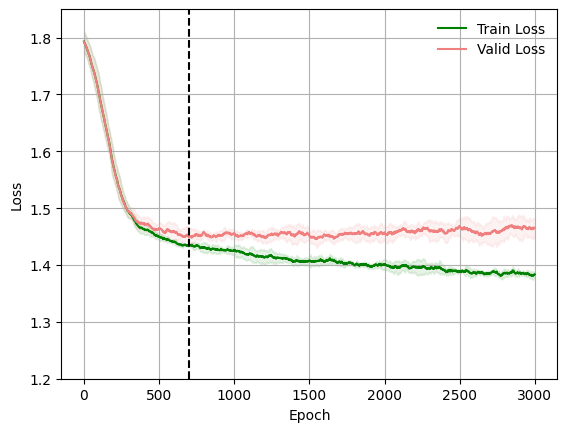

In [133]:
# Plot the epoch loss curve RHC
if plot_loss:
    means_train, stds_train = df_train_rhc.mean().values, df_train_rhc.std().values
    means_valid, stds_valid = df_valid_rhc.mean().values, df_valid_rhc.std().values

    means_train = means_train[:3000]
    stds_train = stds_train[:3000]
    means_valid = means_valid[:3000]
    stds_valid = stds_valid[:3000]

    # means_train
    # plot the iterative learning curve (loss)
    plt.plot(means_train, label='Train Loss', color='green')
    plt.plot(means_valid, label='Valid Loss', color='lightcoral')
    plt.fill_between(np.arange(1,len(means_train)+1), means_train - stds_train, means_train + stds_train, alpha=0.1, color='green')
    plt.fill_between(np.arange(1,len(means_valid)+1), means_valid - stds_valid, means_valid + stds_valid, alpha=0.1, color='lightcoral')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    # plt.title("Iterative Learning Curve (Loss)")
    plt.grid(visible=True)
    plt.legend(frameon=False)
    plt.axvline(700, color='k', linestyle='--')
    # plt.xlim([500,1200])
    plt.ylim([1.2,1.85])
    plt.show()

In [10]:
# re-evaluate RHC with best epoch
best_params2 = gs_rhc.best_params_
best_params2['max_epochs'] = 700 # vary the impacts of epochs

net_rhc2 = NeuralNetClassifier(
    module=RHCModule,
    **best_params2,
    verbose=1,
    callbacks=[EpochScoring(scoring='f1_weighted', name='train_acc', on_train=True), EpochTimer()],
    criterion=nn.CrossEntropyLoss(),
    train_split=ValidSplit(3, stratified=True),
    iterator_train__shuffle=True,
)

RHCModule.register_rhc_training_step()
net_rhc2.fit(X_tr_scaled, y_train)


  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.1904        1.7883       0.2426        1.7876  0.1617
      2       0.1903        1.7876       0.2459        1.7876  0.1263
      3       0.1893        1.7876       0.2459        1.7876  0.1050
      4       0.2014        1.7864       0.2623        1.7861  0.1177
      5       0.2052        1.7858       0.2590        1.7859  0.1268
      6       0.2067        1.7856       0.2656        1.7857  0.1174
      7       0.2049        1.7849       0.2951        1.7845  0.0861
      8       0.2152        1.7834       0.3246        1.7822  0.1116
      9       0.2231        1.7805       0.3279        1.7806  0.0885
     10       0.2277        1.7796       0.3541        1.7795  0.0774
     11       0.2280        1.7790       0.3475        1.7780  0.1085
     12       0.2248        1.7779       0.3475        1.7780  0.1267
     13       0.2251

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=RHCModule(
    (dropout): Dropout(p=0, inplace=False)
    (activation): Tanh()
    (output_activation): Softmax(dim=-1)
    (layers): ModuleList(
      (0): Linear(in_features=11, out_features=20, bias=True)
      (1-2): 2 x Linear(in_features=20, out_features=20, bias=True)
      (3): Linear(in_features=20, out_features=6, bias=True)
    )
  ),
)

(0.0, 19.0)

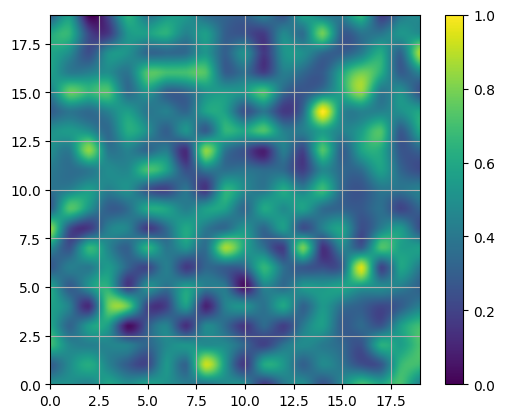

In [11]:
# evaluate RHC weights and visualize
layers_out = list(net_rhc2.module_.parameters())[2].detach().numpy()
z_rhc = (layers_out - layers_out.min())/(layers_out.max() - layers_out.min())
plt.imshow(z_rhc, interpolation='spline16')
plt.colorbar()
plt.grid()
plt.xlim([0,19])
plt.ylim([0,19])

In [114]:
# evaluate final model on test data RHC
ut.final_classifier_evaluation(net_rhc2, X_tr_scaled, X_te_scaled, y_train, y_test)

Model Training Time (s) 77.87068486213684
Model Prediction Time (s): 0.03024005889892578
Accuracy: 0.6506550218340611
Precision: 0.6180086483328484
Recall: 0.6506550218340611
F1-Score: 0.6302289352678353
Manual F1 Score: 0.6339117924323396


In [9]:
# Plot the learning curve RHC
if plot_learning:
    train_sizes, train_scores, test_scores = learning_curve(net_rhc, X_tr_scaled, y_train, train_sizes=np.linspace(0.001, 1.0, 20), cv=5, shuffle=True, n_jobs=-1, scoring='f1_weighted')

    train_scores_mean = train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_mean = test_scores.mean(axis=1)
    test_scores_std = test_scores.std(axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='cyan')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='darkorchid')
    plt.plot(train_sizes, train_scores_mean, label="Training score", color='cyan')
    plt.plot(train_sizes, test_scores_mean, label="Test score", color='darkorchid')
    plt.title("Learning Curve")
    plt.xlabel("Training Dataset Size")
    plt.ylabel("F1 - Score")
    plt.grid(visible=True)
    plt.legend(frameon=False)

In [7]:
# grid search optimal parameters GA
if not load_previous:
    if gridsearch_eval:
        gridsearch_name = "best_param_nn"
        directory_root = './outputdir/NeuralNet'

        net_ga = NeuralNetClassifier(
            module=GAModule,
            module__input_dim=11,
            module__output_dim=6,
            module__hidden_units=5,
            module__hidden_layers=3,
            max_epochs=1000,
            module__population_size=100,
            module__to_mate=150,
            module__to_mutate=30,
            verbose=0,
            callbacks=[EpochScoring(scoring='f1_weighted', name='train_acc', on_train=True), EpochTimer()],
            criterion=nn.CrossEntropyLoss(),
            iterator_train__shuffle=True,
        )
        
        # deactivate skorch-internal train-valid split and verbose logging
        net_ga.set_params(train_split=False, verbose=0)

        default_params = {
            'module__input_dim': [11],
            'module__output_dim': [6],
        }

        # module specific parameters need to begin with 'module__'
        params = {
            'lr': [0.01],
            'max_epochs': [3000],
            'module__hidden_layers': [2],
            'module__hidden_units': [20],
            'module__activation': [nn.Tanh()],
            'module__population_size': [50, 100, 200],
            'module__to_mate': [10, 25, 50],
            'module__to_mutate': [30],
            **default_params,
        }

        GAModule.register_ga_training_step()  
        gs_ga = GridSearchCV(net_ga, params, refit=False, cv=3, scoring='f1_weighted', verbose=10, n_jobs=-1)
        gs_ga.fit(X_tr_scaled, y_train)
        print("best score: {:.3f}, best params: {}".format(gs_ga.best_score_, gs_ga.best_params_))

        # Save the DataFrames as pickle files
        pickle_file_path_ga = os.path.join(directory_root, str(gridsearch_name) + '_ga.pickle')
        with open(pickle_file_path_ga, 'wb') as f:
            pk.dump(gs_ga, f)

Fitting 3 folds for each of 9 candidates, totalling 27 fits
[CV 1/3; 1/9] START lr=0.01, max_epochs=3000, module__activation=Tanh(), module__hidden_layers=2, module__hidden_units=20, module__input_dim=11, module__output_dim=6, module__population_size=50, module__to_mate=10, module__to_mutate=30
[CV 1/3; 1/9] END lr=0.01, max_epochs=3000, module__activation=Tanh(), module__hidden_layers=2, module__hidden_units=20, module__input_dim=11, module__output_dim=6, module__population_size=50, module__to_mate=10, module__to_mutate=30;, score=0.517 total time=78.8min
[CV 2/3; 1/9] START lr=0.01, max_epochs=3000, module__activation=Tanh(), module__hidden_layers=2, module__hidden_units=20, module__input_dim=11, module__output_dim=6, module__population_size=50, module__to_mate=10, module__to_mutate=30
[CV 2/3; 1/9] END lr=0.01, max_epochs=3000, module__activation=Tanh(), module__hidden_layers=2, module__hidden_units=20, module__input_dim=11, module__output_dim=6, module__population_size=50, module__

: 

In [8]:
# evaluate GA on cv=3 (multiple seed) and test 
if not load_previous:
    experiment_name = "neuralnet_ga"
    directory_root = './outputdir/NeuralNet'

    nets_ga = []
    num_seeds = 5
    best_params = gs_ga.best_params_
    for i in range(num_seeds):
        net_ga = NeuralNetClassifier(
            module=GAModule,
            **best_params,
            verbose=0,
            callbacks=[EpochScoring(scoring='f1_weighted', name='train_acc', on_train=True), EpochTimer()],
            criterion=nn.CrossEntropyLoss(),
            train_split=ValidSplit(3, stratified=True),
            iterator_train__shuffle=True,
        )

        GAModule.register_ga_training_step()
        net_ga.fit(X_tr_scaled, y_train)  
        nets_ga.append(net_ga)

    mean_train, mean_valid = [], []
    for i in range(num_seeds):
        mean_train.append(nets_ga[i].history[:, 'train_loss'])
        mean_valid.append(nets_ga[i].history[:, 'valid_loss'])

    df_train_ga = pd.DataFrame(mean_train)
    df_valid_ga = pd.DataFrame(mean_valid)
    ut.data_store([df_train_ga, df_valid_ga], experiment_name, directory_root)

# evaluate final model on test data
ut.final_classifier_evaluation(net_ga, X_tr_scaled, X_te_scaled, y_train, y_test)


Saved files in ./outputdir/NeuralNet\neuralnet


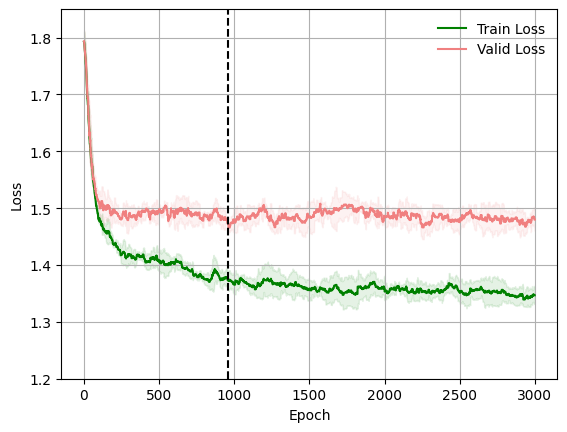

In [126]:
# Plot the epoch loss curve GA
if plot_loss:
    means_train, stds_train = df_train_ga.mean().values, df_train_ga.std().values
    means_valid, stds_valid = df_valid_ga.mean().values, df_valid_ga.std().values

    # plot the iterative learning curve (loss)
    plt.plot(means_train, label='Train Loss', color='green')
    plt.plot(means_valid, label='Valid Loss', color='lightcoral')
    plt.fill_between(np.arange(1,len(means_train)+1), means_train - stds_train, means_train + stds_train, alpha=0.1, color='green')
    plt.fill_between(np.arange(1,len(means_valid)+1), means_valid - stds_valid, means_valid + stds_valid, alpha=0.1, color='lightcoral')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    # plt.title("Iterative Learning Curve (Loss)")
    plt.grid(visible=True)
    plt.legend(frameon=False)
    # plt.axhline(1.44, linestyle='--', color='k')
    plt.axvline(960, linestyle='--', color='k')
    plt.ylim([1.2,1.85])

In [13]:
# re-evalute GA with best epoch
best_params2 = gs_ga.best_params_
best_params2['max_epochs'] = 960 # 960 # vary the impacts of epochs

net_ga2 = NeuralNetClassifier(
    module=GAModule,
    **best_params2,
    verbose=1,
    callbacks=[EpochScoring(scoring='f1_weighted', name='train_acc', on_train=True), EpochTimer()],
    criterion=nn.CrossEntropyLoss(),
    train_split=ValidSplit(3, stratified=True),
    iterator_train__shuffle=True,
)

GAModule.register_ga_training_step()
net_ga2.fit(X_tr_scaled, y_train) 

  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.0948        1.8055       0.0656        1.8062  3.5729
      2       0.0710        1.8041       0.0295        1.8041  3.5864
      3       0.0954        1.8032       0.0951        1.8024  3.1496
      4       0.1167        1.8030       0.0951        1.8024  3.3479
      5       0.1550        1.8001       0.1213        1.7980  3.4877
      6       0.2109        1.7931       0.1213        1.7980  3.2404
      7       0.2455        1.7848       0.2361        1.7825  2.9449
      8       0.2611        1.7780       0.2361        1.7825  2.8163
      9       0.2898        1.7727       0.2820        1.7726  3.3841
     10       0.3159        1.7692       0.2820        1.7726  3.2047
     11       0.3032        1.7700       0.3148        1.7571  2.9729
     12       0.2943        1.7631       0.3148        1.7571  3.0218
     13       0.2760

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=GAModule(
    (dropout): Dropout(p=0, inplace=False)
    (activation): Tanh()
    (output_activation): Softmax(dim=-1)
    (layers): ModuleList(
      (0): Linear(in_features=11, out_features=20, bias=True)
      (1-2): 2 x Linear(in_features=20, out_features=20, bias=True)
      (3): Linear(in_features=20, out_features=6, bias=True)
    )
  ),
)

(0.0, 19.0)

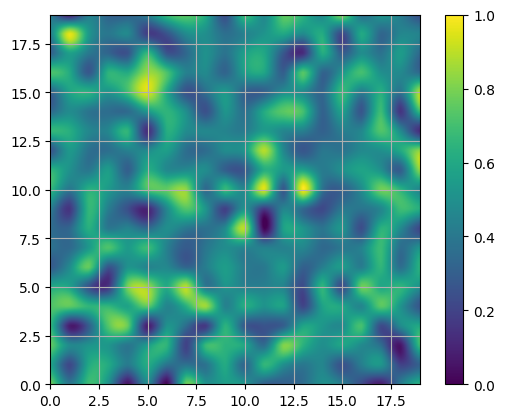

In [14]:
# evaluate GA weights and visualize 
layers_out = list(net_ga2.module_.parameters())[2].detach().numpy()
z_ga = (layers_out - layers_out.min())/(layers_out.max() - layers_out.min())
plt.imshow(z_ga, interpolation='spline16')
plt.colorbar()
plt.grid()
plt.xlim([0,19])
plt.ylim([0,19])


In [140]:
# evaluate final model on test data GA
ut.final_classifier_evaluation(net_ga2, X_tr_scaled, X_te_scaled, y_train, y_test)

Model Training Time (s) 6784.082316637039
Model Prediction Time (s): 0.012132406234741211
Accuracy: 0.6331877729257642
Precision: 0.6094507116074299
Recall: 0.6331877729257642
F1-Score: 0.6204719336165067
Manual F1 Score: 0.6210925278653278


In [ ]:
# Plot the learning curve GA
if plot_learning:
    train_sizes, train_scores, test_scores = learning_curve(net_ga, X_tr_scaled, y_train, train_sizes=np.linspace(0.001, 1.0, 20), cv=5, shuffle=True, n_jobs=-1, scoring='f1_weighted')

    train_scores_mean = train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_mean = test_scores.mean(axis=1)
    test_scores_std = test_scores.std(axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='cyan')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='darkorchid')
    plt.plot(train_sizes, train_scores_mean, label="Training score", color='cyan')
    plt.plot(train_sizes, test_scores_mean, label="Test score", color='darkorchid')
    plt.title("Learning Curve")
    plt.xlabel("Training Dataset Size")
    plt.ylabel("F1 - Score")
    plt.grid(visible=True)
    plt.legend(frameon=False)

In [5]:
# grid search optimal parameters for SA
if not load_previous:
    if gridsearch_eval:
        gridsearch_name = "best_param_nn"
        directory_root = './outputdir/NeuralNet'

        net_sa = NeuralNetClassifier(
            module=SAModule,
            module__input_dim=11,
            module__output_dim=6,
            module__hidden_units=5,
            module__hidden_layers=3,
            max_epochs=1000,
            module__step_size=.1,
            module__t=20000,
            module__cooling=.99,
            verbose=0,
            callbacks=[EpochScoring(scoring='f1_weighted', name='train_acc', on_train=True), EpochTimer()],
            iterator_train__shuffle=True,
        )
        
        # deactivate skorch-internal train-valid split and verbose logging
        net_sa.set_params(train_split=False, verbose=0)

        default_params = {
            'module__input_dim': [11],
            'module__output_dim': [6],
        }

        # module specific parameters need to begin with 'module__': Based on best params backpropagation
        params = {
            'lr': [0.01],
            'max_epochs': [3000],
            'module__hidden_layers': [2],
            'module__hidden_units': [20],
            'module__activation': [nn.Tanh()],
            'module__step_size': [0.1, 0.2],
            'module__t': [10, 100, 1000, 10000],
            'module__cooling': [0.90, 0.99],
            **default_params,
        }

        SAModule.register_sa_training_step()
        gs_sa = GridSearchCV(net_sa, params, refit=False, cv=3, scoring='f1_weighted', verbose=10)
        gs_sa.fit(X_tr_scaled, y_train)
        print("best score: {:.3f}, best params: {}".format(gs_sa.best_score_, gs_sa.best_params_))

        # Save the DataFrames as pickle files
        pickle_file_path_sa = os.path.join(directory_root, str(gridsearch_name) + '_sa.pickle')
        with open(pickle_file_path_sa, 'wb') as f:
            pk.dump(gs_sa, f)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV 1/3; 1/12] START lr=0.01, max_epochs=3000, module__activation=Tanh(), module__cooling=0.99, module__hidden_layers=2, module__hidden_units=20, module__input_dim=11, module__output_dim=6, module__step_size=0.1, module__t=20000
[CV 1/3; 1/12] END lr=0.01, max_epochs=3000, module__activation=Tanh(), module__cooling=0.99, module__hidden_layers=2, module__hidden_units=20, module__input_dim=11, module__output_dim=6, module__step_size=0.1, module__t=20000;, score=0.589 total time= 4.8min
[CV 2/3; 1/12] START lr=0.01, max_epochs=3000, module__activation=Tanh(), module__cooling=0.99, module__hidden_layers=2, module__hidden_units=20, module__input_dim=11, module__output_dim=6, module__step_size=0.1, module__t=20000
[CV 2/3; 1/12] END lr=0.01, max_epochs=3000, module__activation=Tanh(), module__cooling=0.99, module__hidden_layers=2, module__hidden_units=20, module__input_dim=11, module__output_dim=6, module__step_size=0.1, module__t=

In [6]:
# evaluate SA on cv=3 (multiple seed) and test
if not load_previous:
    experiment_name = "neuralnet_sa"
    directory_root = './outputdir/NeuralNet'

    nets_sa= [] 
    num_seeds = 5
    best_params = gs_sa.best_params_
    for i in range(num_seeds):

        net_sa = NeuralNetClassifier(
            module=SAModule,
            **best_params,
            verbose=0,
            callbacks=[EpochScoring(scoring='f1_weighted', name='train_acc', on_train=True), EpochTimer()],
            criterion=nn.CrossEntropyLoss(),
            train_split=ValidSplit(3, stratified=True),
            iterator_train__shuffle=True,
        )

        SAModule.register_sa_training_step()
        net_sa.fit(X_tr_scaled, y_train)
        nets_sa.append(net_sa)

    mean_train, mean_valid = [], []
    for i in range(num_seeds):
        mean_train.append(nets_sa[i].history[:, 'train_loss'])
        mean_valid.append(nets_sa[i].history[:, 'valid_loss'])

    df_train_sa = pd.DataFrame(mean_train)
    df_valid_sa = pd.DataFrame(mean_valid)
    ut.data_store([df_train_sa, df_valid_sa], experiment_name, directory_root)

# evaluate final model on test data
ut.final_classifier_evaluation(net_sa, X_tr_scaled, X_te_scaled, y_train, y_test)

Saved files in ./outputdir/NeuralNet\neuralnet
Model Training Time (s) 305.78364515304565
Model Prediction Time (s): 0.007521152496337891
Accuracy: 0.6637554585152838
Precision: 0.6282825054484366
Recall: 0.6637554585152838
F1-Score: 0.6451905099789487
Manual F1 Score: 0.6455320263217407


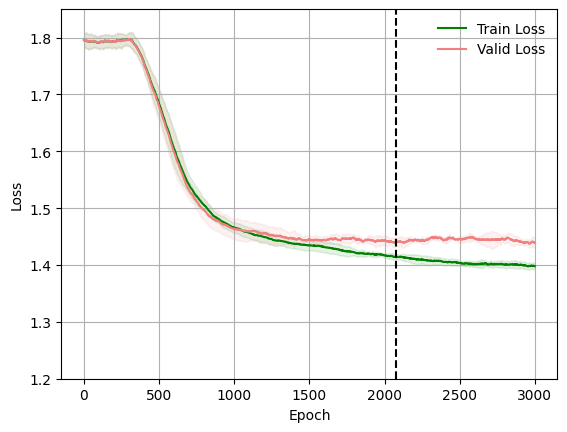

In [125]:
# Plot the epoch loss curve SA
if plot_loss:
    means_train, stds_train = df_train_sa.mean().values, df_train_sa.std().values
    means_valid, stds_valid = df_valid_sa.mean().values, df_valid_sa.std().values

    # plot the iterative learning curve (loss)
    plt.plot(means_train, label='Train Loss', color='green')
    plt.plot(means_valid, label='Valid Loss', color='lightcoral')
    plt.fill_between(np.arange(1,len(means_train)+1), means_train - stds_train, means_train + stds_train, alpha=0.1, color='green')
    plt.fill_between(np.arange(1,len(means_valid)+1), means_valid - stds_valid, means_valid + stds_valid, alpha=0.1, color='lightcoral')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    # plt.title("Iterative Learning Curve (Loss)")
    plt.grid(visible=True)
    plt.legend(frameon=False)
    # plt.axhline(1.44, linestyle='--', color='k')
    plt.axvline(2075, linestyle='--', color='k')
    plt.ylim([1.2,1.85])

In [15]:
# re-evaluate SA best epochs
best_params2 = gs_sa.best_params_
best_params2['max_epochs'] = 2075 # vary the impacts of epochs
net_sa2 = NeuralNetClassifier(
    module=SAModule,
    **best_params2,
    verbose=1,
    callbacks=[EpochScoring(scoring='f1_weighted', name='train_acc', on_train=True), EpochTimer()],
    criterion=nn.CrossEntropyLoss(),
    train_split=ValidSplit(3, stratified=True),
    iterator_train__shuffle=True,
)

SAModule.register_sa_training_step()
net_sa2.fit(X_tr_scaled, y_train)

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=SAModule(
    (dropout): Dropout(p=0, inplace=False)
    (activation): Tanh()
    (output_activation): Softmax(dim=-1)
    (layers): ModuleList(
      (0): Linear(in_features=11, out_features=20, bias=True)
      (1-2): 2 x Linear(in_features=20, out_features=20, bias=True)
      (3): Linear(in_features=20, out_features=6, bias=True)
    )
  ),
)

(0.0, 19.0)

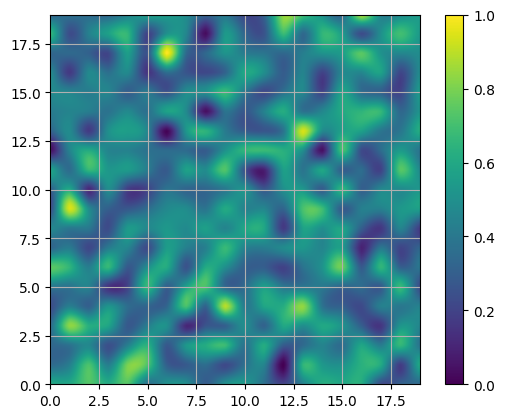

In [17]:
# evaluate SA weights and visualize
layers_out = list(net_sa2.module_.parameters())[2].detach().numpy()
z_sa = (layers_out - layers_out.min())/(layers_out.max() - layers_out.min())
plt.imshow(z_sa, interpolation='spline16', norm='linear')
plt.colorbar()
plt.grid()
plt.xlim([0,19])
plt.ylim([0,19])

In [137]:
# evaluate final model on test data SA
ut.final_classifier_evaluation(net_sa2, X_tr_scaled, X_te_scaled, y_train, y_test)

Model Training Time (s) 213.23263788223267
Model Prediction Time (s): 0.008547306060791016
Accuracy: 0.6506550218340611
Precision: 0.6163890638241244
Recall: 0.6506550218340611
F1-Score: 0.6329328938370606
Manual F1 Score: 0.6330586983047667


In [ ]:
# Plot the learning curve SA
if plot_learning:
    train_sizes, train_scores, test_scores = learning_curve(net_sa, X_tr_scaled, y_train, train_sizes=np.linspace(0.001, 1.0, 20), cv=5, shuffle=True, n_jobs=-1, scoring='f1_weighted')

    train_scores_mean = train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_mean = test_scores.mean(axis=1)
    test_scores_std = test_scores.std(axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='cyan')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='darkorchid')
    plt.plot(train_sizes, train_scores_mean, label="Training score", color='cyan')
    plt.plot(train_sizes, test_scores_mean, label="Test score", color='darkorchid')
    plt.title("Learning Curve")
    plt.xlabel("Training Dataset Size")
    plt.ylabel("F1 - Score")
    plt.grid(visible=True)
    plt.legend(frameon=False)

In [6]:
# grid search optimal parameters for adam/sgd backpropagation
if not load_previous:
    if gridsearch_eval:
        gridsearch_name = "best_param_nn"
        directory_root = './outputdir/NeuralNet'

        net_bac = NeuralNetClassifier(
            module=BackpropModule,
            module__input_dim=11,
            module__output_dim=6,
            module__hidden_units=5,
            module__hidden_layers=3,
            max_epochs=1000,
            verbose=0,
            callbacks=[EpochScoring(scoring='f1_weighted', name='train_acc', on_train=True), EpochTimer()],
            criterion=nn.CrossEntropyLoss,
            optimizer=optim.Adam,
            iterator_train__shuffle=True,
        )

        # deactivate skorch-internal train-valid split and verbose logging
        net_bac.set_params(train_split=False, verbose=0)

        default_params = {
            'module__input_dim': [11],
            'module__output_dim': [6],
        }

        # module specific parameters need to begin with 'module__'
        params = {
            'lr': [0.01, 0.02],
            'optimizer': [optim.Adam, optim.SGD],
            'max_epochs': [1000, 2000, 5000],
            'module__hidden_layers': [2, 3],
            'module__hidden_units': [10, 20],
            'module__activation': [nn.ReLU(), nn.Tanh()],
            **default_params,
        }

        gs_bac = GridSearchCV(net_bac, params, refit=False, cv=3, scoring='f1_weighted', verbose=10)
        gs_bac.fit(X_tr_scaled, y_train)
        print("best score: {:.3f}, best params: {}".format(gs_bac.best_score_, gs_bac.best_params_))

        # Save the DataFrames as pickle files
        pickle_file_path_bac = os.path.join(directory_root, str(gridsearch_name) + '_bac.pickle')
        with open(pickle_file_path_bac, 'wb') as f:
            pk.dump(gs_bac, f)

Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV 1/3; 1/96] START lr=0.01, max_epochs=1000, module__activation=ReLU(), module__hidden_layers=2, module__hidden_units=10, module__input_dim=11, module__output_dim=6, optimizer=<class 'torch.optim.adam.Adam'>
[CV 1/3; 1/96] END lr=0.01, max_epochs=1000, module__activation=ReLU(), module__hidden_layers=2, module__hidden_units=10, module__input_dim=11, module__output_dim=6, optimizer=<class 'torch.optim.adam.Adam'>;, score=0.540 total time=  45.3s
[CV 2/3; 1/96] START lr=0.01, max_epochs=1000, module__activation=ReLU(), module__hidden_layers=2, module__hidden_units=10, module__input_dim=11, module__output_dim=6, optimizer=<class 'torch.optim.adam.Adam'>
[CV 2/3; 1/96] END lr=0.01, max_epochs=1000, module__activation=ReLU(), module__hidden_layers=2, module__hidden_units=10, module__input_dim=11, module__output_dim=6, optimizer=<class 'torch.optim.adam.Adam'>;, score=0.526 total time=  44.0s
[CV 3/3; 1/96] START lr=0.01, max_ep

FileNotFoundError: [Errno 2] No such file or directory: './outputdir/NeuralNet\\best_param_nn_bac.pickle'

In [28]:
# evaluate BP on cv=3 (multiple seed) and test
if not load_previous:
    experiment_name = "NeuralNet_bac"
    directory_root = './outputdir/'

    nets_bac= [] 
    num_seeds = 5
    best_params = gs_bac.best_params_
    for i in range(num_seeds):
        net_bac = NeuralNetClassifier(
            module=BackpropModule,
            **best_params,
            verbose=0,
            callbacks=[EpochScoring(scoring='f1_weighted', name='train_acc', on_train=True), EpochTimer()],
            criterion=nn.CrossEntropyLoss(),
            train_split=ValidSplit(3, stratified=True),
            iterator_train__shuffle=True,
        )

        net_bac.fit(X_tr_scaled, y_train)
        nets_bac.append(net_bac)

    mean_train, mean_valid = [], []
    for i in range(num_seeds):
        mean_train.append(nets_bac[i].history[:, 'train_loss'])
        mean_valid.append(nets_bac[i].history[:, 'valid_loss'])

    df_train_bac = pd.DataFrame(mean_train)
    df_valid_bac = pd.DataFrame(mean_valid)
    ut.data_store([df_train_bac, df_valid_bac], experiment_name, directory_root)

# evaluate final model on test data
ut.final_classifier_evaluation(net_bac, X_tr_scaled, X_te_scaled, y_train, y_test)

Saved files in ./outputdir/NeuralNet
Model Training Time (s) 48.96438956260681
Model Prediction Time (s): 0.006321907043457031
Accuracy: 0.6506550218340611
Precision: 0.6203967793487445
Recall: 0.6506550218340611
F1-Score: 0.6347574377194831
Manual F1 Score: 0.6351657416909362


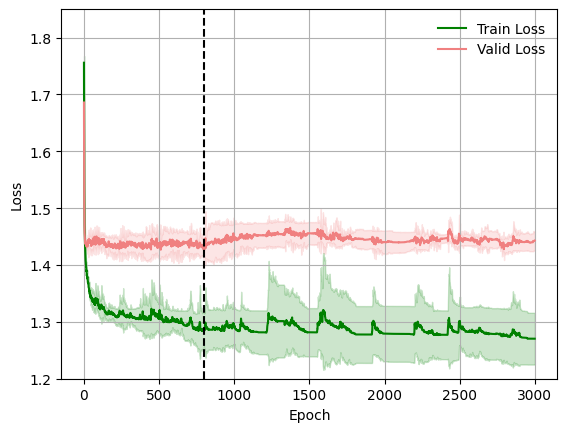

In [194]:
# Plot the epoch loss curve BP
if plot_loss:
    means_train, stds_train = df_train_bac.mean().values, df_train_bac.std().values
    means_valid, stds_valid = df_valid_bac.mean().values, df_valid_bac.std().values


    means_train = means_train[:3000]
    stds_train = stds_train[:3000]
    means_valid = means_valid[:3000]
    stds_valid = stds_valid[:3000]

    # plot the iterative learning curve (loss)
    plt.figure()
    plt.plot(means_train, label='Train Loss', color='green')
    plt.plot(means_valid, label='Valid Loss', color='lightcoral')
    plt.fill_between(np.arange(1,len(means_train)+1), means_train - stds_train, means_train + stds_train, alpha=0.2, color='green')
    plt.fill_between(np.arange(1,len(means_valid)+1), means_valid - stds_valid, means_valid + stds_valid, alpha=0.2, color='lightcoral')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    # plt.title("Iterative Learning Curve (Loss)")
    plt.grid(visible=True)
    plt.legend(frameon=False)
    plt.axvline(800, linestyle='--', color='k')
    # plt.xlim([-25, 5100])
    plt.ylim([1.2,1.85])

In [7]:
# re-evalaute BP using best epoch
best_params2 = gs_bac.best_params_
best_params2['max_epochs'] = 800 # vary the impacts of epochs
net_bac3 = NeuralNetClassifier(
    module=BackpropModule,
    **best_params2,
    verbose=1,
    callbacks=[EpochScoring(scoring='f1_weighted', name='train_acc', on_train=True), EpochTimer()],
    criterion=nn.CrossEntropyLoss(),
    train_split=ValidSplit(3, stratified=True),
    iterator_train__shuffle=True,
)

net_bac3.fit(X_tr_scaled, y_train)

  epoch    train_acc    train_loss    valid_acc    valid_loss     dur
-------  -----------  ------------  -----------  ------------  ------
      1       0.3275        1.7430       0.4852        1.6628  0.0572
      2       0.4061        1.6165       0.5082        1.5466  0.0545
      3       0.4631        1.5351       0.5443        1.4968  0.0540
      4       0.5450        1.4832       0.5934        1.4497  0.0503
      5       0.5618        1.4585       0.6000        1.4453  0.0819
      6       0.5828        1.4438       0.5967        1.4437  0.0604
      7       0.5963        1.4315       0.6131        1.4375  0.0729
      8       0.6051        1.4255       0.5967        1.4373  0.0566
      9       0.6210        1.4159       0.6033        1.4360  0.0489
     10       0.6125        1.4161       0.6098        1.4306  0.0434
     11       0.6204        1.4080       0.6164        1.4333  0.0655
     12       0.6115        1.4067       0.6033        1.4373  0.0821
     13       0.6274

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=BackpropModule(
    (dropout): Dropout(p=0, inplace=False)
    (activation): Tanh()
    (output_activation): Softmax(dim=-1)
    (layers): ModuleList(
      (0): Linear(in_features=11, out_features=20, bias=True)
      (1-2): 2 x Linear(in_features=20, out_features=20, bias=True)
      (3): Linear(in_features=20, out_features=6, bias=True)
    )
  ),
)

(0.0, 19.0)

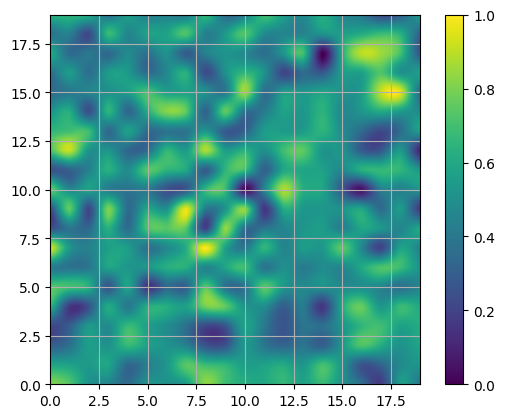

In [8]:
# evaluate BP weights and visualize
layers_out = list(net_bac3.module_.parameters())[2].detach().numpy()
z_bac = (layers_out - layers_out.min())/(layers_out.max() - layers_out.min())
plt.imshow(z_bac, interpolation='spline16', norm='linear')
plt.colorbar()
plt.grid()
plt.xlim([0,19])
plt.ylim([0,19])

In [ ]:
# evaluate final model on test data BP
ut.final_classifier_evaluation(net_bac2, X_tr_scaled, X_te_scaled, y_train, y_test)

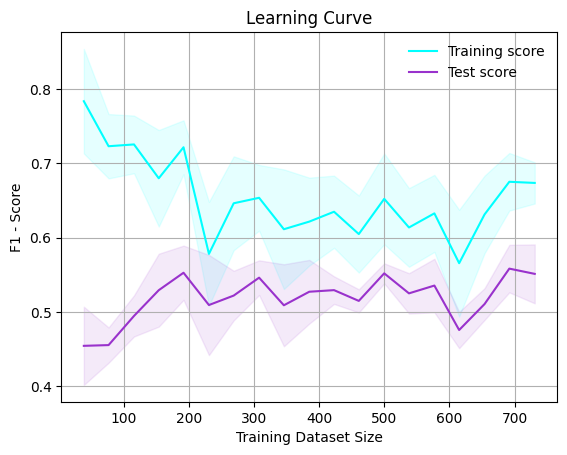

In [15]:
# Plot the learning curve BP
if plot_learning:
    train_sizes, train_scores, test_scores = learning_curve(net_bac, X_tr_scaled, y_train, train_sizes=np.linspace(0.001, 1.0, 20), cv=5, shuffle=True, n_jobs=-1, scoring='f1_weighted')

    train_scores_mean = train_scores.mean(axis=1)
    train_scores_std = train_scores.std(axis=1)
    test_scores_mean = test_scores.mean(axis=1)
    test_scores_std = test_scores.std(axis=1)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='cyan')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='darkorchid')
    plt.plot(train_sizes, train_scores_mean, label="Training score", color='cyan')
    plt.plot(train_sizes, test_scores_mean, label="Test score", color='darkorchid')
    plt.title("Learning Curve")
    plt.xlabel("Training Dataset Size")
    plt.ylabel("F1 - Score")
    plt.grid(visible=True)
    plt.legend(frameon=False)

Chi-square distance: 0.7805148023126153
Chi-square distance: 1.24790840615452
Chi-square distance: 1.462713749998334
P-value: 1.0
P-value: 1.0
P-value: 1.0


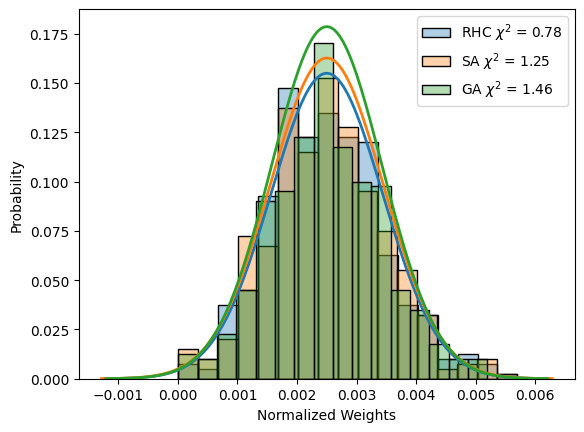

In [51]:
# compare weight distributions of RO on RHC, SA, and GA
import numpy as np
from scipy.stats import chisquare
# Generate two histograms

norm_bac = z_bac.flatten().astype('float64')/z_bac.flatten().astype('float64').sum()
norm_rhc = z_rhc.flatten().astype('float64')/z_rhc.flatten().astype('float64').sum()
norm_sa = z_sa.flatten().astype('float64')/z_sa.flatten().astype('float64').sum()
norm_ga = z_ga.flatten().astype('float64')/z_ga.flatten().astype('float64').sum()

norm_bac[norm_bac == 0.] = 0.00001
norm_rhc[norm_rhc == 0.] = 0.00001
norm_sa[norm_sa == 0.] = 0.00001
norm_ga[norm_ga == 0.] = 0.00001

# Calculate the Chi-square distance
dist_rhc_bac = chisquare(norm_rhc, norm_bac)
dist_sa_bac = chisquare(norm_sa, norm_bac)
dist_ga_bac = chisquare(norm_ga, norm_bac)
print("Chi-square distance:", dist_rhc_bac.statistic)
print("Chi-square distance:", dist_sa_bac.statistic)
print("Chi-square distance:", dist_ga_bac.statistic)
print("P-value:", dist_rhc_bac.pvalue) 
print("P-value:", dist_sa_bac.pvalue) 
print("P-value:", dist_ga_bac.pvalue) 


import seaborn as sns
from scipy.stats import norm

def normal(mean, std, histmax=False, color="black"):
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = norm.pdf(x, mean, std)
    if histmax:
        p = p*histmax/max(p)
    z = plt.plot(x, p, color, linewidth=2)

# Get the default Matplotlib color cycle
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Plot the histograms and normal distributions
fig, ax = plt.subplots()

ax1 = sns.histplot(x=norm_rhc, stat="probability", color=default_colors[0], edgecolor='black', alpha=0.35, label=f'RHC $\\chi^2$ = {np.round(dist_rhc_bac[0], 2)}')
normal(norm_rhc.mean(), norm_rhc.std(), histmax=ax1.get_ylim()[1], color=default_colors[0])

ax2 = sns.histplot(x=norm_sa, stat="probability", color=default_colors[1], edgecolor='black', alpha=0.35, label=f'SA $\\chi^2$ = {np.round(dist_sa_bac[0], 2)}')
normal(norm_sa.mean(), norm_sa.std(), histmax=ax2.get_ylim()[1], color=default_colors[1])

ax3 = sns.histplot(x=norm_ga, stat="probability", color=default_colors[2], edgecolor='black', alpha=0.35, label=f'GA $\\chi^2$ = {np.round(dist_ga_bac[0], 2)}')
normal(norm_ga.mean(), norm_ga.std(), histmax=ax3.get_ylim()[1], color=default_colors[2])

# Add legend and show plot
plt.legend()
plt.xlabel('Normalized Weights')
plt.show()
